In [7]:
import logging
import time
import matplotlib.pyplot as plt
import cflib.crtp
import numpy as np

from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.utils import uri_helper
import cflib.crtp
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = uri_helper.uri_from_env(default='radio://0/80/2M/E7E7E7E7E7')

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)
######################################################################
def generateTrajectory(t, phi_1=180,phi_2=0,phi_3=180, W_max=1400):
    #traj generation as per the eqn:  in paper 
    # receives arguments based on the number of flips required
    gamma_1=phi_1/W_max
    beta_1=-3/4*(gamma_1**-3)*W_max
    gamma_3=phi_3/W_max
    beta_3=-3/4*(gamma_3**-3)*W_max
    delta_1=2*gamma_1
    delta_2_prime=delta_1+phi_2/W_max
    if(t<=delta_1):
        W=beta_1/3*((t-gamma_1)**3)-beta_1*(gamma_1**2)*t+beta_1*(gamma_1**3)/3
    elif(t>delta_1 and t<=delta_2_prime):
        W=W_max
    else:
        W=beta_3/3*((gamma_3+delta_2_prime-t)**3)-beta_3*(gamma_3**2)*(2*gamma_3+delta_2_prime-t)+beta_3*(gamma_3**3)/3
    return W

In [351]:
class FlipPlanner:
    def __init__(self, FLIP=1):
        if (FLIP==1):
            print("SINGLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 180
            self.Phi_g2 = 0
            self.Phi_g3 = 180
            self.omega_max = 1400
            self.asc_time = 0.2
            self.duration = 0.49
        if (FLIP==2):
            print("DOUBLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 200
            self.Phi_g2 = 300
            self.Phi_g3 = 220
            self.omega_max = 1600
            self.asc_time = 0.25
            self.duration = 0.75
        if (FLIP==3):
            print("TRIPLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 220
            self.Phi_g2 = 520
            self.Phi_g3 = 340
            self.omega_max = 2000
            self.asc_time = 0.3
            self.duration = 0.8 

    def calculateStages(self):
        # Stage 1
        self.gamma1 = self.Phi_g1/self.omega_max
        self.beta1 = -(3/4)*self.omega_max/self.gamma1**3
        self.omega_dot_max1 = (3/4)*self.omega_max**2/self.Phi_g1
        self.delta1 = 2*self.gamma1
        # Stage 2
        self.delta2 = self.Phi_g2/self.omega_max
        # Stage 3
        self.gamma3 = self.Phi_g3/self.omega_max
        self.beta3 = -(3/4)*self.omega_max/self.gamma3**3
        self.omega_dot_max3 = (3/4)*self.omega_max**2/self.Phi_g3
        self.delta3 = 2*self.gamma3
        print("CALCULATED, RUN")

    def generateTraj2(self, t, phi_g):
        """ Generates reference angular rate trajectory 
        considering generalized flipping angle

        :param t: time since starting flipping
        :param phi_g: generalized flipping angle

        """
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta2n = -1
        if phi_g <= Phi_g1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0

        if phi_g > Phi_g1 and phi_g <= (Phi_g1 + Phi_g2):
            omega_d = omega_max
            omega_dot_d = 0

        if phi_g > (Phi_g1 + Phi_g2) and phi_g <= (Phi_g1 + Phi_g2 + Phi_g3):
            if delta2n == -1:
                delta2n = t # actual end time of stage 2

            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2

        if phi_g > (Phi_g1 + Phi_g2 + Phi_g3):
            omega_d = 0
            omega_dot_d = 0
            
        return omega_d

    def generateTraj1(self, t):
        """ Generates reference angular rate trajectory 
        w/o considering generalized flipping angle

        :param t: time since starting flipping

        """        
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        delta2 = self.delta2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta3 = self.delta3

        if t <= delta1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0

        if (delta1 < t and t <= delta1 + delta2):
            omega_d = omega_max
            omega_dot_d = 0

        if (delta1 + delta2 < t and t <= delta1 + delta2 + delta3):
            delta2n = delta1 + delta2
            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2

        if t > delta1 + delta2 + delta3:
            omega_d = 0
            omega_dot_d = 0
            
        return omega_d

SINGLE FLIP, PLEASE CALCULATE
CALCULATED, RUN


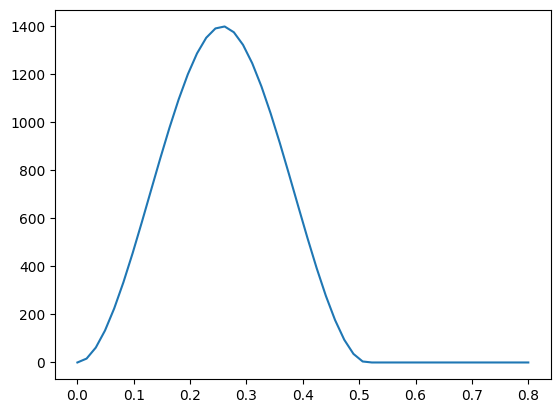

In [343]:
# TEST FUNCTIONS
planner = FlipPlanner(FLIP=1)
planner.calculateStages()
# print(vars(planner))
import numpy as np
t = np.linspace(0, 0.8)
rate = map(planner.generateTraj1, t)
# rate = map(lambda x: 2*x, list(t))
rate = np.array(list(rate))
plt.plot(t,list(rate))


In [359]:
log_keys = ['controller.rollRate','stateEstimateZ.rateRoll','stateEstimate.roll']
# log_keys = ['stateEstimateZ.x', 'stateEstimateZ.y', 'stateEstimateZ.z']

lg_stab = LogConfig(name='flip', period_in_ms=10)
lg_data = {}
for key in log_keys:
    lg_stab.add_variable( key, 'float')
    lg_data[key.split('.')[1]] = []

if __name__ == '__main__':
    # Initialize the low-level drivers
    planner = FlipPlanner(FLIP=1)
    planner.calculateStages()

    cflib.crtp.init_drivers(enable_debug_driver=False)
    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf
        h = 0.8   # stabilization height TODO: for each case

        # print('Initializing as PID')
        cf.param.set_value('stabilizer.controller', '1')

        cf.param.set_value('kalman.resetEstimation', '1')
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)

        # print('Reset Kalman filter.')
        print('Taking off!')
        cf.commander.send_setpoint(0, 0, 0, 0)

        # drone take off to a height
        for y in range(10):        
            cf.commander.send_hover_setpoint(0, 0, 0, h*y/10)
            time.sleep(0.1)

        for _ in range(50):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)


        # execute trajectory
        # step 1: ascend
        print('Ascending!')
        asc_time = planner.asc_time
        asc_thrust = 60000  # max thrust
        t_start = time.time()
        while True:
            t_current = time.time()
            t = abs(t_current-t_start)  # time since starting flipping
            if t > asc_time:
                break
            # cf.commander.send_setpoint(0, 0, 0, asc_thrust)
            cf.commander.send_hover_setpoint(0, 0, 0, 2*h)

        # step 2: flip (tracking desired angular rate)
        print('Flipping!')
        cf.param.set_value('flightmode.stabModeRoll', '0')    # to rate mode
        cf.param.set_value('stabilizer.tumbleCheckEn', '0')    # disable tumble check

        waypoints = []
        time_list = []
        # TODO: take flipping angle to switch trajectory
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            t_current = time.time()
            t = abs(t_current-t_start)  # time since starting flipping
            flip_thrust = 40000

            for log_entry in logger:
                w = planner.generateTraj1(t)
                waypoints.append(w)
                time_list.append(t)
                cf.commander.send_setpoint(w,0,0,flip_thrust)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)
                # time.sleep(0.05)    # TODO: what is the max frequency
                t_current = time.time()
                t = abs(t_current-t_start)
                if t > planner.duration:
                    break

                
                # cf.commander.send_stop_setpoint()

        
        # step 3: stabilize
        # at a height
        print('Stabilizing!')
        cf.param.set_value('flightmode.stabModeRoll', '1')    # to angle mode
        # cf.param.set_value('stabilizer.controller', '3')
        cf.param.set_value('stabilizer.tumbleCheckEn', '1')    # enable tumble check
        h = 2.5
        for _ in range(3):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)
        h = 0.5           
        for _ in range(40):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)

        # drone landing
        print("Landing!")
        for y in range(10):
            cf.commander.send_hover_setpoint(0, 0, 0, (10 - y)*h / 10)
            time.sleep(0.1)

        cf.commander.send_stop_setpoint()

        # print(waypoints)
        # print(time_list)

SINGLE FLIP, PLEASE CALCULATE
CALCULATED, RUN
Taking off!
Ascending!
Flipping!
Stabilizing!
Landing!


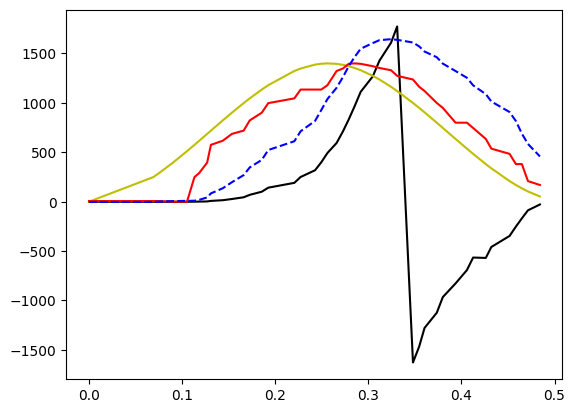

In [360]:
# plt.plot(time_list,180*np.ones(len(time_list)))

# plt.plot(time_list, np.array(lg_data['x'])/1000,'b--',time_list, np.array(lg_data['y'])/1000,'r')
# plt.figure()
# plt.plot(time_list, np.array(lg_data['z'])/1000)

plt.plot(time_list, np.array(lg_data['roll'])*10,'k',time_list,waypoints,'y', time_list, lg_data['rollRate'],'r',time_list, np.array(lg_data['rateRoll'])*180/3.14/1000,'b--')

# plt.figure()
# plt.plot(,time_list, lg_data['rollRate'],'b--')
# plt.figure()
# plt.plot(time_list, lg_data['roll'])
